# Exercises & Extra-curriculum

## 0. Prerequisites

In [ ]:
# Loading libraries
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to import torchinfo, install it if fails
try:
    from torchinfo import summary
except:
    print("[INFO] torchinfo doesn't exist, installing it")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import going_modular directory, get it from GitHub if it fails
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] going_modular scripts don't exist, downloding them")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] torchinfo doesn't exist, installing it
[INFO] going_modular scripts don't exist, downloding them
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3815, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 3815 (delta 242), reused 403 (delta 199), pack-reused 3357
Receiving objects: 100% (3815/3815), 650.61 MiB | 37.79 MiB/s, done.
Resolving deltas: 100% (2198/2198), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Loading libraries
import os
import zipfile
import requests

from pathlib import Path

# Setup dir
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
zipfile_path = data_path / "pizza_steak_sushi.zip"

# Create a directory and process files
if image_path.is_dir():
    print(f"{image_path} exists")
else:
    print(f"{image_path} doesn't exist, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(zipfile_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data")
        f.write(request.content)

    with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
        print("Unzipping data")
        zip_ref.extractall(image_path)

    os.remove(zipfile_path)

data/pizza_steak_sushi doesn't exist, creating one
Unzipping data


In [ ]:
# Setup dir
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Get pretrained model with weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 74.7MB/s]


In [ ]:
# Setup same transforms from pretrained model
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Setup hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 0.001
EPOCHS = 5

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transform,
                                                                               batch_size=BATCH_SIZE,
                                                                               num_workers=NUM_WORKERS)

In [ ]:
# Print model summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Freeze feature layers
for param in model.features.parameters():
    param.requires_grad=False

In [ ]:
# Update classifier to be 3 instead of 1000
output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280,
              out_features=output_shape)
).to(device)

In [ ]:
# Create loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup train and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

# End the timer
end_time = timer()

# Print total time
print(f"Total training time: {end_time - start_time:.4f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0961 | train_acc: 0.3750 | test_loss: 0.9209 | test_acc: 0.6004
Epoch: 2 | train_loss: 0.8650 | train_acc: 0.8281 | test_loss: 0.8275 | test_acc: 0.7538
Epoch: 3 | train_loss: 0.7590 | train_acc: 0.8516 | test_loss: 0.7783 | test_acc: 0.7434
Epoch: 4 | train_loss: 0.7069 | train_acc: 0.7539 | test_loss: 0.6713 | test_acc: 0.8144
Epoch: 5 | train_loss: 0.6204 | train_acc: 0.7969 | test_loss: 0.6543 | test_acc: 0.8258
Total training time: 24.1917 seconds


In [ ]:
# Get plot_loss_curves() function from helper_functions.py, download it if it doesn't exist
try:
    from helper_functions import plot_loss_curves
except:
    print(f"[INFO] helper_functions.py doesn't exist, downloading it")
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

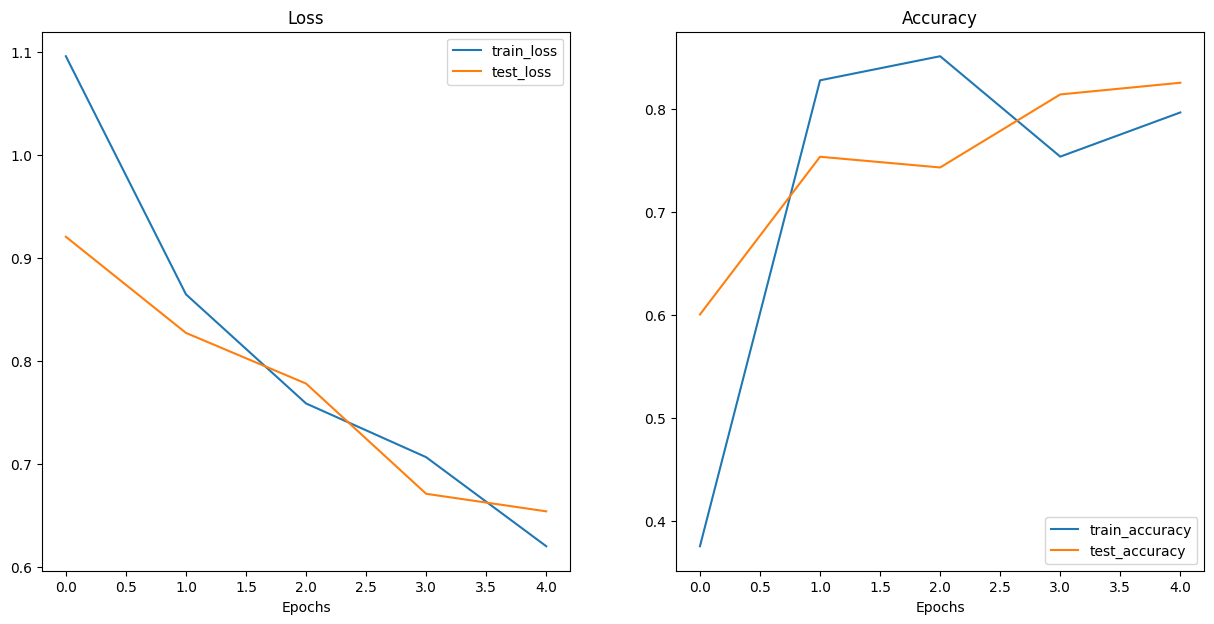

In [ ]:
# Plot the curve
plot_loss_curves(results)

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out 03. PyTorch Computer Vision section 10 for ideas

In [ ]:
# See if torchmetrics exist, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [ ]:
from tqdm.auto import tqdm

# Make predictions with a trained model
y_preds = []
labels = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred_logit = model(X)
        y_pred = torch.softmax(y_pred_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        labels.append(y.cpu())
    y_pred_tensor = torch.cat(y_preds)
    labels_tensor = torch.cat(labels)

  0%|          | 0/3 [00:00<?, ?it/s]

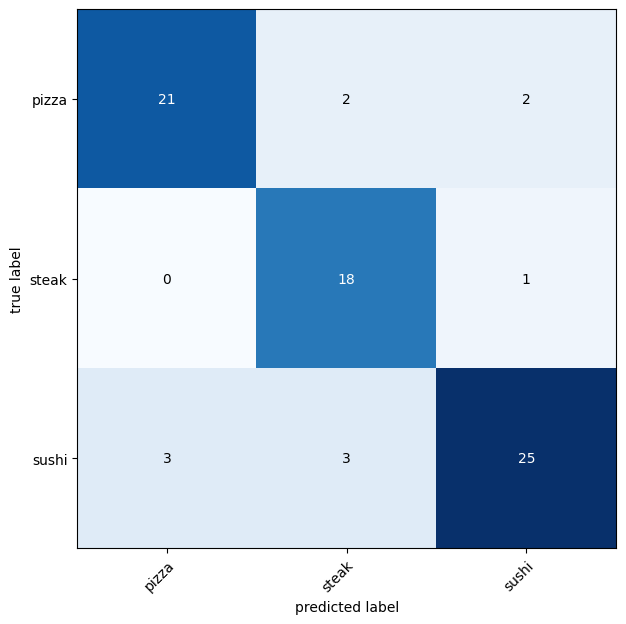

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=labels_tensor)

plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
- Predicting across all of the test dataset, storing the labels and predicted probabilities.
- Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
- Plot the top 5 "most wrong" images, why do you think the model got these wrong?

### 2.1. Using list comprehension

In [ ]:
# # Make predictions with a trained model
# y_preds = []
# y_pred_probs = []
# labels = []
# model.eval()
# with torch.inference_mode():
#     for X, y in tqdm(test_dataloader):
#         X, y = X.to(device), y.to(device)
#         y_pred_logit = model(X)
#         y_pred_probs.append(torch.softmax(y_pred_logit, dim=1).cpu())
#         y_pred = torch.softmax(y_pred_logit, dim=1).argmax(dim=1)
#         y_preds.append(y_pred.cpu())
#         labels.append(y.cpu())
#     y_pred_tensor = torch.cat(y_preds)
#     labels_tensor = torch.cat(labels)
#     y_pred_probs_tensor = torch.cat(y_pred_probs)

In [ ]:
# Make predictions with a trained model
from pathlib import Path
from PIL import Image

y_preds = []
y_pred_probs = []
y_pred_class = []

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
labels = [path.parent.stem for path in test_data_paths]

model.eval()
with torch.inference_mode():
    for path in tqdm(test_data_paths):
        # Get prediction
        img = Image.open(path)                                  # open image
        transformed_image = auto_transform(img).unsqueeze(0)    # transform image and add batch dimension
        y_pred_logit = model(transformed_image.to(device))
        y_pred_probs.append(torch.softmax(y_pred_logit, dim=1).unsqueeze(0).max().cpu().item())
        y_pred = torch.softmax(y_pred_logit, dim=1).argmax(dim=1)
        y_pred_class.append(class_names[y_pred.cpu()])

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
# Wrong predictions using list comprehension
# Things adding to the list:
# 1. Wrong pred probabilities
# 2. Pred label
# 3. Truth label
# 4. Location of the sample for visualization

wrong_pred = [(y_pred_probs[i],
               y_pred_class[i],
               labels[i], test_data_paths[i])
               for i in range(len(labels)) if y_pred_class[i] != labels[i]]
wrong_pred

[(0.45185428857803345,
  'steak',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg')),
 (0.40532076358795166,
  'pizza',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg')),
 (0.389110803604126,
  'steak',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg')),
 (0.3562931418418884,
  'pizza',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg')),
 (0.4281071126461029,
  'pizza',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg')),
 (0.4731604754924774,
  'steak',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg')),
 (0.4889681339263916,
  'sushi',
  'steak',
  PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg')),
 (0.6367501020431519,
  'sushi',
  'pizza',
  PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg')),
 (0.3964362144470215,
  'steak',
  'pizza',
  PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg')),
 (0.3843111991882324,
  'sushi',
  'piz

In [ ]:
wrong_pred = sorted(wrong_pred, reverse=True)
wrong_pred

[(0.6367501020431519,
  'sushi',
  'pizza',
  PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg')),
 (0.5567160248756409,
  'steak',
  'pizza',
  PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg')),
 (0.4889681339263916,
  'sushi',
  'steak',
  PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg')),
 (0.4731604754924774,
  'steak',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg')),
 (0.45185428857803345,
  'steak',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg')),
 (0.4281071126461029,
  'pizza',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg')),
 (0.40532076358795166,
  'pizza',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg')),
 (0.3964362144470215,
  'steak',
  'pizza',
  PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg')),
 (0.389110803604126,
  'steak',
  'sushi',
  PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg')),
 (0.3843111991882324,
  'sushi',
  'pi

In [ ]:
wrong_pred[0][-1]

PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg')

In [ ]:
import pandas as pd

wrong_pred_df = pd.DataFrame(wrong_pred, columns=["Probs", "Pred", "True", "Path"])
wrong_pred_df

Probs   Pred   True                                           Path
0   0.636750  sushi  pizza   data/pizza_steak_sushi/test/pizza/344397.jpg
1   0.556716  steak  pizza  data/pizza_steak_sushi/test/pizza/2871261.jpg
2   0.488968  sushi  steak  data/pizza_steak_sushi/test/steak/1285886.jpg
3   0.473160  steak  sushi   data/pizza_steak_sushi/test/sushi/684266.jpg
4   0.451854  steak  sushi  data/pizza_steak_sushi/test/sushi/3196729.jpg
5   0.428107  pizza  sushi  data/pizza_steak_sushi/test/sushi/2521706.jpg
6   0.405321  pizza  sushi  data/pizza_steak_sushi/test/sushi/3837522.jpg
7   0.396436  steak  pizza  data/pizza_steak_sushi/test/pizza/2508636.jpg
8   0.389111  steak  sushi  data/pizza_steak_sushi/test/sushi/2276986.jpg
9   0.384311  sushi  pizza   data/pizza_steak_sushi/test/pizza/971934.jpg
10  0.356293  pizza  sushi   data/pizza_steak_sushi/test/sushi/343036.jpg

In [ ]:
wrong_pred[0]

(0.6367501020431519,
 'sushi',
 'pizza',
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'))

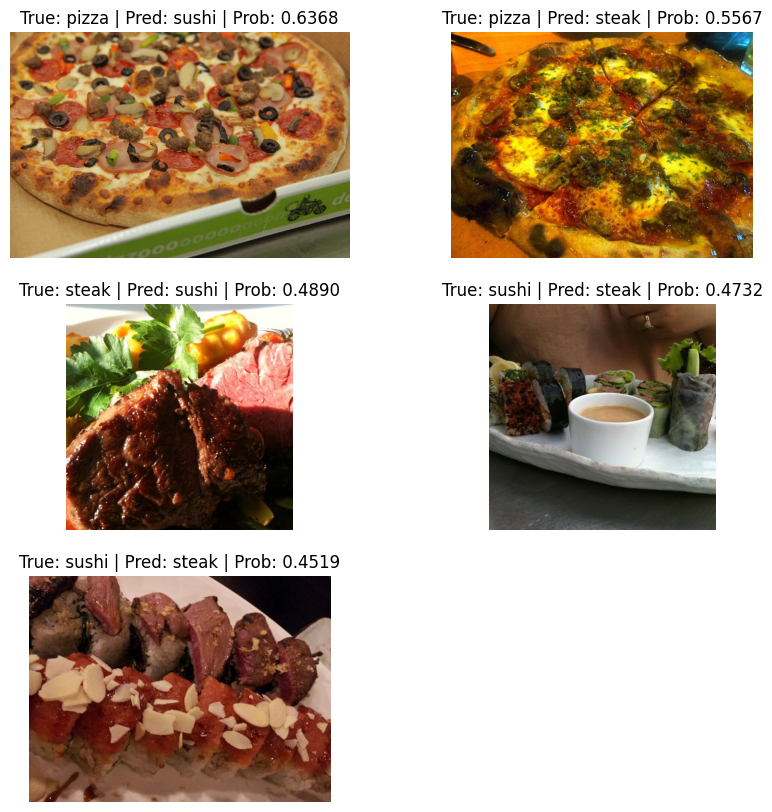

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.imshow(Image.open(wrong_pred[i][-1]))
    plt.title(f"True: {wrong_pred[i][-2]} | Pred: {wrong_pred[i][1]} | Prob: {wrong_pred[i][0]:.4f}")
    plt.axis("off");

### 2.2 Using function, dictionary -> dataframe

In [ ]:
# Create a DatFrame with sample, label, prediction, pred prob
# Sort DataFrame by correct (doest label == prediction)
# Sort DataFrame by pred prob (descending)
# Plot the top 5 "most wrong"

# Get all test data paths
from pathlib import Path
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        pred_dict = {}

        # Get sample path
        pred_dict["image_path"] = path

        # Get class name
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Get prediction
        img = Image.open(path)                          # open image
        transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            # Make sure things in the dictionary are back on the CPU
            pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
            pred_dict['pred_class'] = pred_class

        # Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # Add the dictionary to the list of preds
        test_pred_list.append(pred_dict)

    return test_pred_list

In [ ]:
test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=auto_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.45185428857803345,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.46267372369766235,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4421593248844147,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.40532076358795166,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6091541647911072,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
  'class_name': '

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

# Sort df by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
54   data/pizza_steak_sushi/test/pizza/344397.jpg      pizza   0.636750   
73  data/pizza_steak_sushi/test/pizza/2871261.jpg      pizza   0.556716   
31  data/pizza_steak_sushi/test/steak/1285886.jpg      steak   0.488968   
28   data/pizza_steak_sushi/test/sushi/684266.jpg      sushi   0.473160   
0   data/pizza_steak_sushi/test/sushi/3196729.jpg      sushi   0.451854   

   pred_class  correct  
54      sushi    False  
73      steak    False  
31      sushi    False  
28      steak    False  
0       steak    False

In [ ]:
for i in top_5_most_wrong.iterrows():
    print(i[1])

image_path    data/pizza_steak_sushi/test/pizza/344397.jpg
class_name                                           pizza
pred_prob                                          0.63675
pred_class                                           sushi
correct                                              False
Name: 54, dtype: object
image_path    data/pizza_steak_sushi/test/pizza/2871261.jpg
class_name                                            pizza
pred_prob                                          0.556716
pred_class                                            steak
correct                                               False
Name: 73, dtype: object
image_path    data/pizza_steak_sushi/test/steak/1285886.jpg
class_name                                            steak
pred_prob                                          0.488968
pred_class                                            sushi
correct                                               False
Name: 31, dtype: object
image_path    data/pizza_steak_su

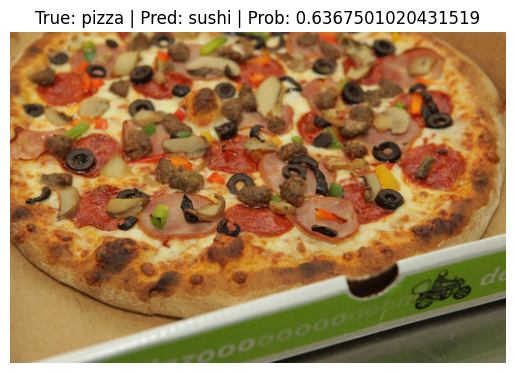

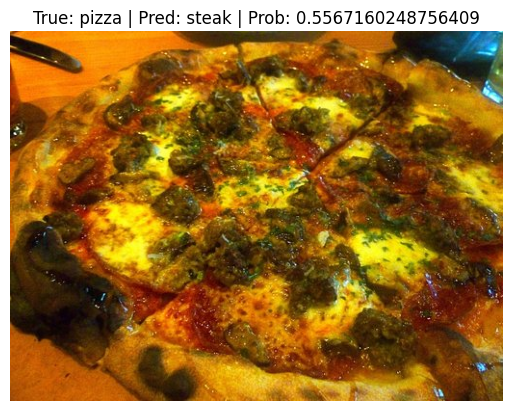

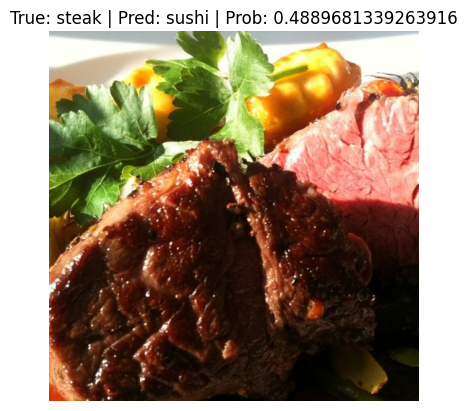

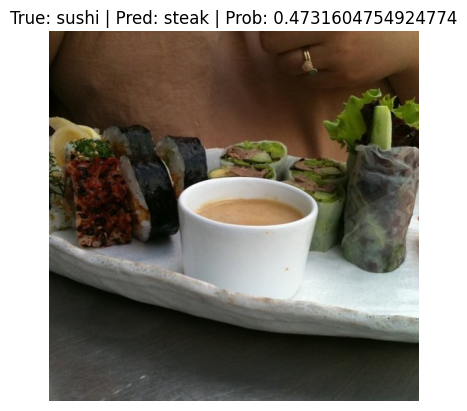

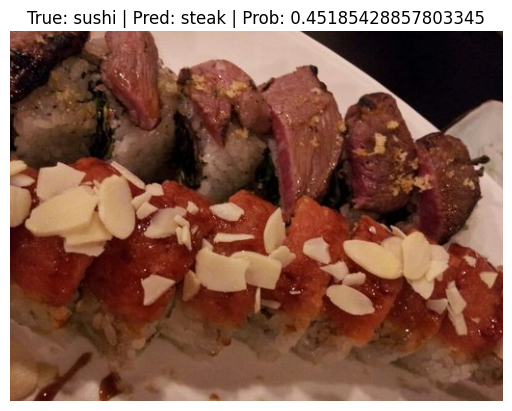

In [ ]:
import torchvision
import matplotlib.pyplot as plt

# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
    row = row[1]
    image_path = row[0]
    true_label = row[1]
    pred_prob = row[2]
    pred_class = row[3]

    # Plot the image and various details
    img = torchvision.io.read_image(str(image_path))    # get image as tensor
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))                    # matplotlib likes images in [height, width, color_channels]
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob}")
    plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

### 3.1 Method 1

In [ ]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device,
                        mean: List[int] = [0.485, 0.456, 0.406],
                        std: List[int] = [0.229, 0.224, 0.225]):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_img = image_transform(img).unsqueeze(dim=0).to(device)
        target_image_pred = model(transformed_img)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.4f}")
        plt.axis(False);

data/pizza_image.jpg already exists


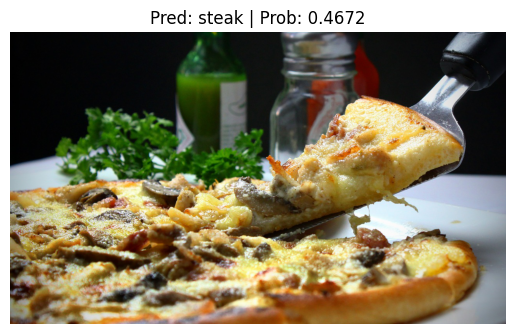

In [ ]:
# pizza image
import requests

custom_image_path = data_path / "pizza_image.jpg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://cdn.pixabay.com/photo/2014/04/22/02/56/pizza-329523_1280.jpg")
        print(f"Downloading {custom_image_path}")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists")

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

data/steak_image.jpg already exists


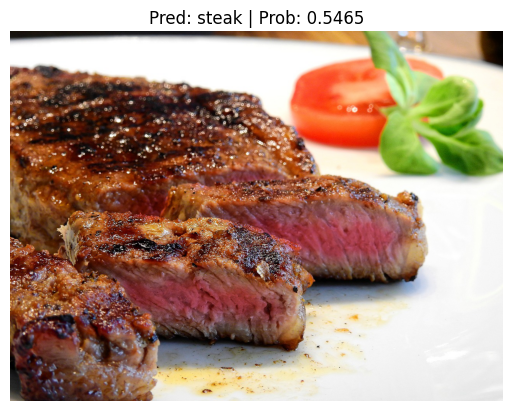

In [ ]:
# steak image
import requests

custom_image_path2 = data_path / "steak_image.jpg"

if not custom_image_path2.is_file():
    with open(custom_image_path2, "wb") as f:
        request = requests.get("https://cdn.pixabay.com/photo/2017/04/30/09/30/steak-2272464_1280.jpg")
        print(f"Downloading {custom_image_path2}")
        f.write(request.content)
else:
    print(f"{custom_image_path2} already exists")

pred_and_plot_image(model=model,
                    image_path=custom_image_path2,
                    class_names=class_names)

data/water_drop_image.jpg already exists


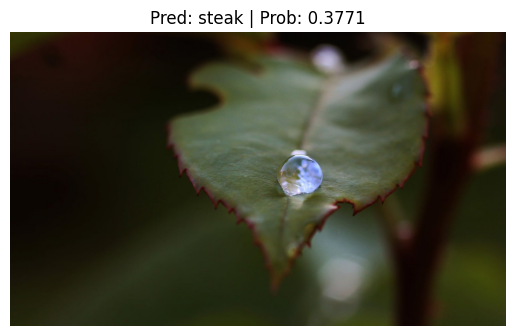

In [ ]:
# random image off of category
import requests

custom_image_path3 = data_path / "water_drop_image.jpg"

if not custom_image_path3.is_file():
    with open(custom_image_path3, "wb") as f:
        request = requests.get("https://cdn.pixabay.com/photo/2023/05/21/19/45/rose-8009275_1280.jpg")
        print(f"Downloading {custom_image_path3}")
        f.write(request.content)
else:
    print(f"{custom_image_path3} already exists")

pred_and_plot_image(model=model,
                    image_path=custom_image_path3,
                    class_names=class_names)

### 3.2 Method 2

--2023-05-29 06:48:33--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 146.75.30.208, 2a04:4e42:79::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.30.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4343742 (4.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a.1’

photo-1588315029754 100%[===================>]   4.14M  --.-KB/s    in 0.01s   

2023-05-29 06:48:33 (303 MB/s) - ‘photo-1588315029754-2dd089d39a1a.1’ saved [4343742/4343742]



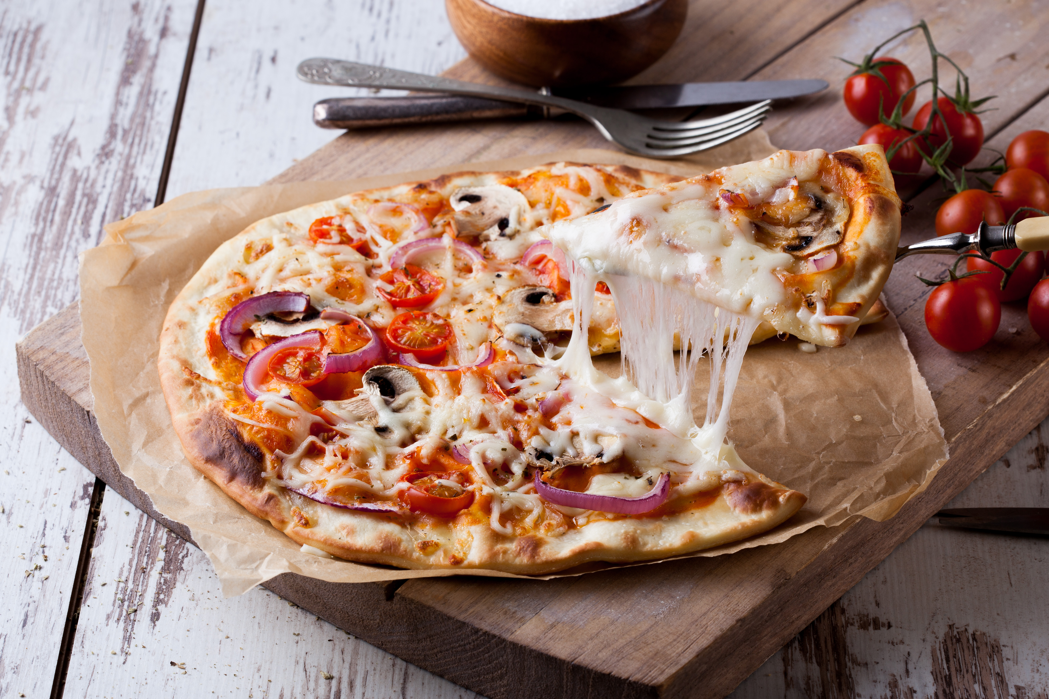

In [ ]:
# Get an image of pizza/steak/sushi
from PIL import Image
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

with Image.open("pizza.jpg") as img:
    # Reduce the image size and width by 5
    (width, height) = (img.width // 5, img.height // 5)
    img_resized = img.resize((width, height))
img_resized

In [ ]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
    # open image
    image = Image.open(image_path)
    transformed_image = transform(image)

    model.eval()
    with torch.inference_mode():
        pred_logit = model(transformed_image.unsqueeze(0).to(device))
        pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_names[pred_label]}")
    plt.axis("off");

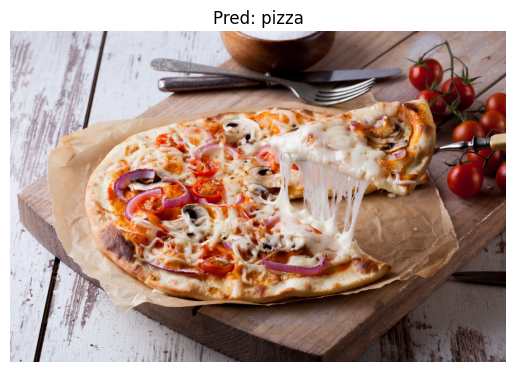

In [ ]:
pred_and_plot(image_path = "pizza.jpg",
              model=model,
              transform=auto_transform,
              class_names=class_names)

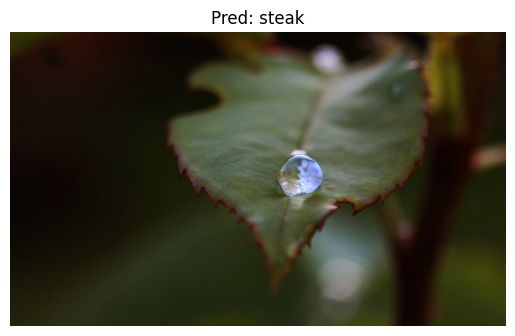

In [ ]:
pred_and_plot(image_path = "data/water_drop_image.jpg",
              model=model,
              transform=auto_transform,
              class_names=class_names)

## 4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [ ]:
import torchvision
from torch import nn

model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model.features.parameters():
    param.requires_grad=False

model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup train and save the results
model_1_results = engine.train(model=model_1,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

# End the timer
end_time = timer()

# Print total time
print(f"Total training time: {end_time - start_time:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7742 | train_acc: 0.6445 | test_loss: 0.2188 | test_acc: 0.9280
Epoch: 2 | train_loss: 0.1928 | train_acc: 0.9844 | test_loss: 0.1993 | test_acc: 0.9489
Epoch: 3 | train_loss: 0.0792 | train_acc: 0.9883 | test_loss: 0.1683 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5011 | train_acc: 0.8594 | test_loss: 0.2001 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.0936 | train_acc: 0.9961 | test_loss: 0.1943 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.2453 | train_acc: 0.8672 | test_loss: 0.2785 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.1501 | train_acc: 0.8672 | test_loss: 0.2046 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.1720 | train_acc: 0.8750 | test_loss: 0.3476 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3833 | train_acc: 0.8516 | test_loss: 0.3732 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.1878 | train_acc: 0.8555 | test_loss: 0.2501 | test_acc: 0.9072
Total training time: 34.6522 seconds


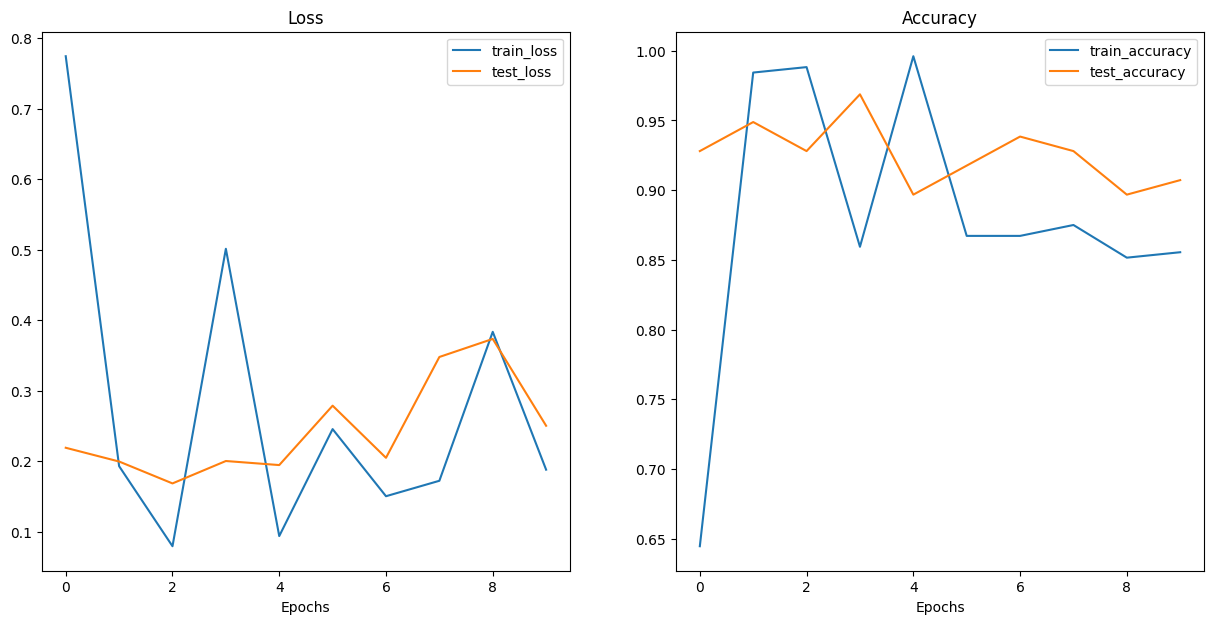

In [ ]:
plot_loss_curves(model_1_results)

If we train for longer, it looks like we get slightly lower loss and potentially higher accuracy, but our model starts to look like it overfits if we train for too long.

Potentially data augmentation or a learning rate decay (lowering the learning rate over time) can help to prevent overfitting

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak, and Sushi images.
- The [20% Pizza, Steak, and Sushi datasets](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) are on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb)

In [ ]:
# Loading libraries
import os
import zipfile
import requests

from pathlib import Path

# Setup dir
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20"
zipfile_path = data_path / "pizza_steak_sushi_20_percent.zip"

# Create a directory and process files
if image_path.is_dir():
    print(f"{image_path} exists")
else:
    print(f"{image_path} doesn't exist, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(zipfile_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading data")
        f.write(request.content)

    with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
        print("Unzipping data")
        zip_ref.extractall(image_path)

    os.remove(zipfile_path)

data/pizza_steak_sushi_20 exists


In [ ]:
train_dir_20 = image_path / "train"
test_dir_20 = image_path / "test"

train_dir_20, test_dir_20

(PosixPath('data/pizza_steak_sushi_20/train'),
 PosixPath('data/pizza_steak_sushi_20/test'))

In [ ]:
train_dataloader_20, test_dataloader_20, class_names = data_setup.create_dataloaders(train_dir=train_dir_20,
                                                                                     test_dir=test_dir_20,
                                                                                     transform=auto_transform,
                                                                                     batch_size=BATCH_SIZE,
                                                                                     num_workers=NUM_WORKERS)

In [ ]:
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model_2.features.parameters():
    param.requires_grad=False

torch.manual_seed(42)
model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup train and save the results
model_2_results = engine.train(model=model_2,
                               train_dataloader=train_dataloader_20,
                               test_dataloader=test_dataloader_20,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

# End the timer
end_time = timer()

# Print total time
print(f"Total training time: {end_time - start_time:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9829 | train_acc: 0.5542 | test_loss: 0.6711 | test_acc: 0.8824
Epoch: 2 | train_loss: 0.7129 | train_acc: 0.7937 | test_loss: 0.5583 | test_acc: 0.8818
Epoch: 3 | train_loss: 0.5935 | train_acc: 0.8104 | test_loss: 0.4814 | test_acc: 0.9040
Epoch: 4 | train_loss: 0.4579 | train_acc: 0.9021 | test_loss: 0.4336 | test_acc: 0.8693
Epoch: 5 | train_loss: 0.4602 | train_acc: 0.8542 | test_loss: 0.4090 | test_acc: 0.8858
Epoch: 6 | train_loss: 0.4511 | train_acc: 0.8438 | test_loss: 0.3748 | test_acc: 0.9159
Epoch: 7 | train_loss: 0.4445 | train_acc: 0.8333 | test_loss: 0.3445 | test_acc: 0.9159
Epoch: 8 | train_loss: 0.4257 | train_acc: 0.8417 | test_loss: 0.3624 | test_acc: 0.8580
Epoch: 9 | train_loss: 0.3636 | train_acc: 0.8792 | test_loss: 0.3200 | test_acc: 0.9102
Epoch: 10 | train_loss: 0.3661 | train_acc: 0.8792 | test_loss: 0.3122 | test_acc: 0.9131
Total training time: 57.1088 seconds


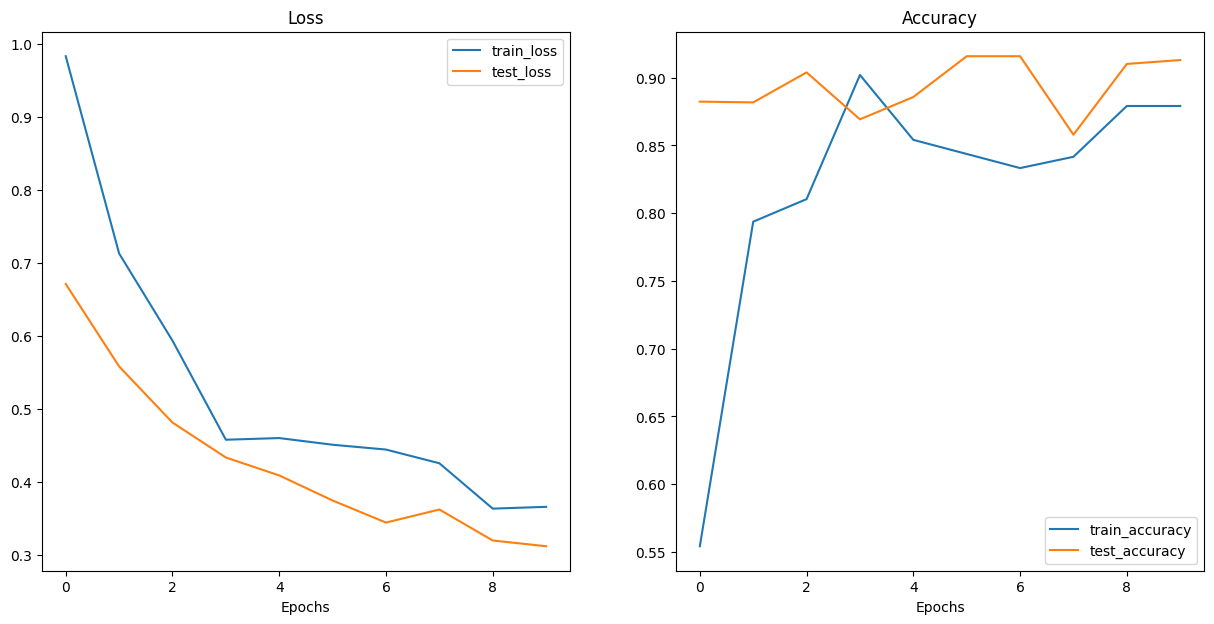

In [ ]:
plot_loss_curves(model_2_results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
- You'll have to change the size of the classifier layer to suit our problem.
- You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?

In [ ]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b2(weights=weights)

model_3.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Setup same transforms from pretrained model
auto_transform_b2 = weights.transforms()
auto_transform_b2

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader_20_b2, test_dataloader_20_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir_20,
                                                                                           test_dir=test_dir_20,
                                                                                           transform=auto_transform_b2,
                                                                                           batch_size=BATCH_SIZE,
                                                                                           num_workers=NUM_WORKERS)

In [ ]:
for param in model_3.features.parameters():
    param.requires_grad=False

torch.manual_seed(42)

model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1408,
              out_features=len(class_names))
).to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(),
                                  lr=0.001)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup train and save the results
model_3_results = engine.train(model=model_3,
                               train_dataloader=train_dataloader_20_b2,
                               test_dataloader=test_dataloader_20_b2,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

# End the timer
end_time = timer()

# Print total time
print(f"Total training time: {end_time - start_time:.4f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9729 | train_acc: 0.5583 | test_loss: 0.7356 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7212 | train_acc: 0.8500 | test_loss: 0.5849 | test_acc: 0.9381
Epoch: 3 | train_loss: 0.5807 | train_acc: 0.8583 | test_loss: 0.4883 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4471 | train_acc: 0.9021 | test_loss: 0.4308 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4332 | train_acc: 0.8896 | test_loss: 0.3878 | test_acc: 0.9506
Epoch: 6 | train_loss: 0.4155 | train_acc: 0.8896 | test_loss: 0.3488 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4237 | train_acc: 0.8708 | test_loss: 0.3240 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3841 | train_acc: 0.8917 | test_loss: 0.3374 | test_acc: 0.9506
Epoch: 9 | train_loss: 0.3697 | train_acc: 0.8958 | test_loss: 0.3081 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3535 | train_acc: 0.8604 | test_loss: 0.2797 | test_acc: 0.9625
Total training time: 71.5372 seconds


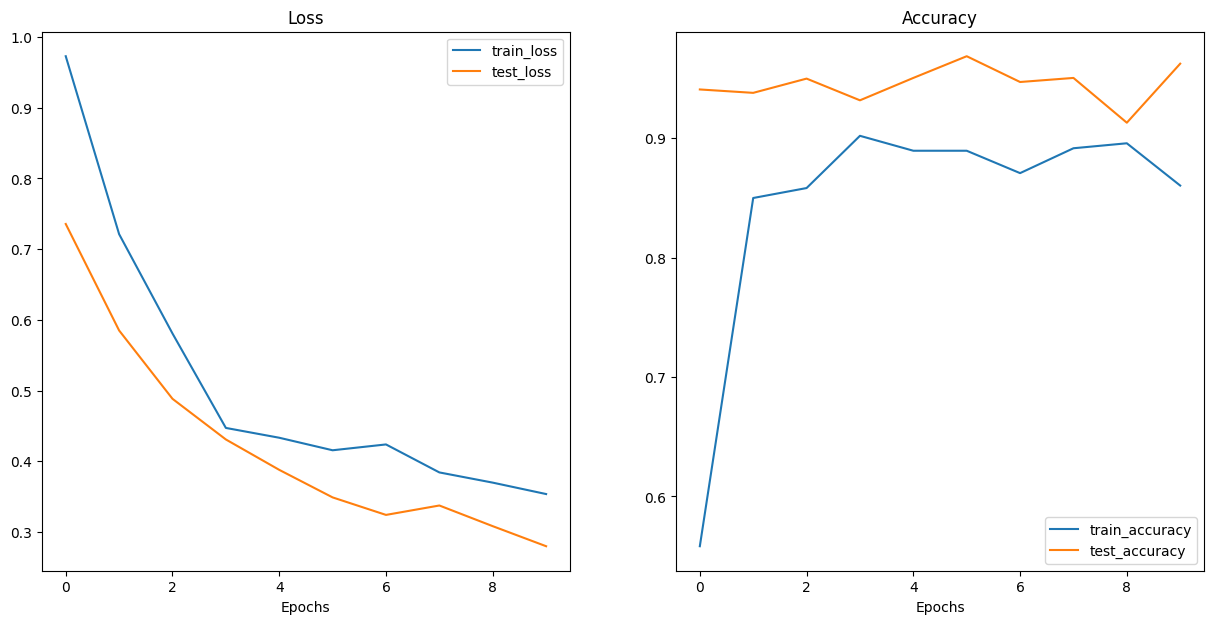

In [ ]:
plot_loss_curves(model_3_results)